In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder # Added OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier # Example of another model
from sklearn.metrics import accuracy_score, classification_report
from sklearn.compose import ColumnTransformer # For robust preprocessing
from sklearn.pipeline import Pipeline
import pickle # For saving/loading
import joblib # Often preferred for scikit-learn models

sns.set_style("whitegrid")

In [2]:
# Set style for plots
%matplotlib inline
sns.set_style("whitegrid")


# Load the datasets

In [10]:
try:
    crop_df = pd.read_csv('Crop_recommendation.csv')
    fertilizer_df = pd.read_csv('Fertilizer Prediction.csv')
    print("Datasets loaded successfully!")
except FileNotFoundError:
    print("Make sure 'Crop_recommendation.csv' and 'Fertilizer Prediction.csv' are in the same directory.")
    # As a fallback, let's use the content provided in the prompt if files are not found
    crop_data_string = """N,P,K,temperature,humidity,ph,rainfall,label
90,42,43,20.87974371,82.00274423,6.502985292000001,202.9355362,rice
... (rest of the crop data) ...
120,16,51,27.99901833,91.64193051,6.547041902999999,23.28618248,muskmelon""" # Truncated for brevity

    fertilizer_data_string = """Temparature,Humidity ,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
26,52,38,Sandy,Maize,37,0,0,Urea
... (rest of the fertilizer data) ...
29,58,57,Black,Sugarcane,12,0,10,20-20""" # Truncated for brevity

    from io import StringIO
    if 'crop_df' not in locals():
      try:
          crop_df = pd.read_csv(StringIO(crop_data_string)) # Replace with full data string
          print("Crop data loaded from string.")
      except Exception as e:
          print(f"Error loading crop data from string: {e}")
          print("Please ensure the full CSV content is pasted if using string loading.")

    if 'fertilizer_df' not in locals():
      try:
          fertilizer_df = pd.read_csv(StringIO(fertilizer_data_string)) # Replace with full data string
          print("Fertilizer data loaded from string.")
          # Clean up column names if needed
          fertilizer_df.columns = fertilizer_df.columns.str.strip()
      except Exception as e:
          print(f"Error loading fertilizer data from string: {e}")
          print("Please ensure the full CSV content is pasted if using string loading.")

# If files were loaded, fertilizer_df might have leading/trailing spaces in column names
if 'fertilizer_df' in locals() and hasattr(fertilizer_df, 'columns'):
    fertilizer_df.columns = fertilizer_df.columns.str.strip()

Datasets loaded successfully!


Project 1: Crop Recommendation System

Goal: Predict the label (crop type) given soil nutrient levels (N, P, K) and environmental conditions (temperature, humidity, pH, rainfall). This is a multi-class classification problem.

#Exploratory Data Analysis (EDA) for Crop Recommendation


--- Crop Recommendation Dataset ---
First 5 rows:
     N   P   K  temperature   humidity        ph    rainfall label
0  90  42  43    20.879744  82.002744  6.502985  202.935536  rice
1  85  58  41    21.770462  80.319644  7.038096  226.655537  rice
2  60  55  44    23.004459  82.320763  7.840207  263.964248  rice
3  74  35  40    26.491096  80.158363  6.980401  242.864034  rice
4  78  42  42    20.130175  81.604873  7.628473  262.717340  rice

Shape of data: (2200, 8)

Data types:
 N                int64
P                int64
K                int64
temperature    float64
humidity       float64
ph             float64
rainfall       float64
label           object
dtype: object

Missing values:
 N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64

Descriptive statistics:
                  N            P            K  temperature     humidity  \
count  2200.000000  2200.000000  2200.000000  2

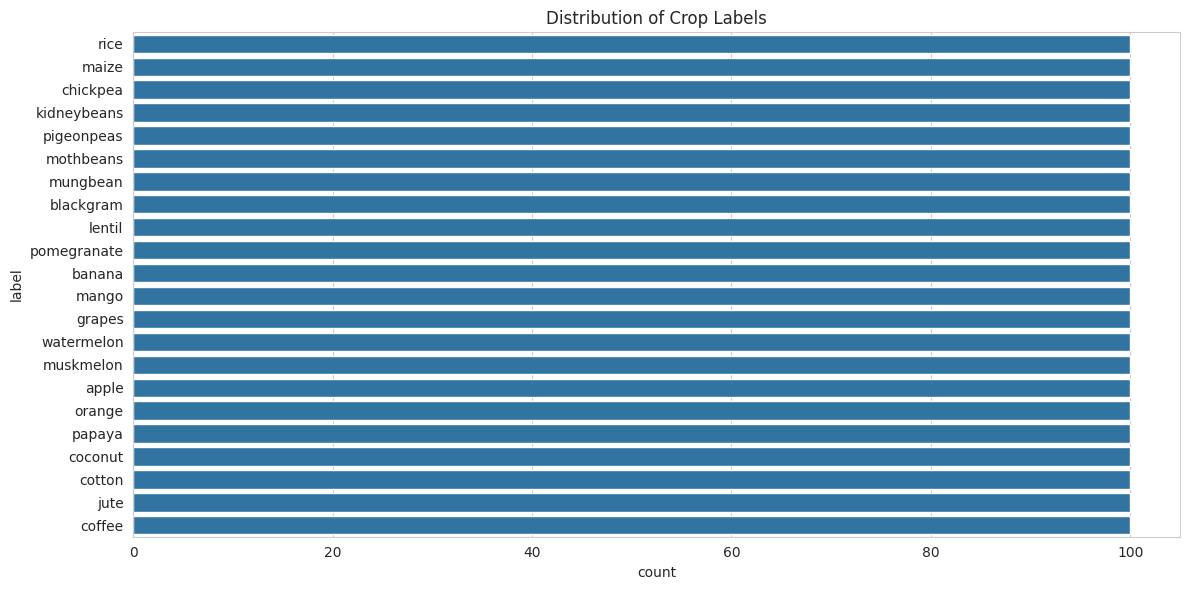

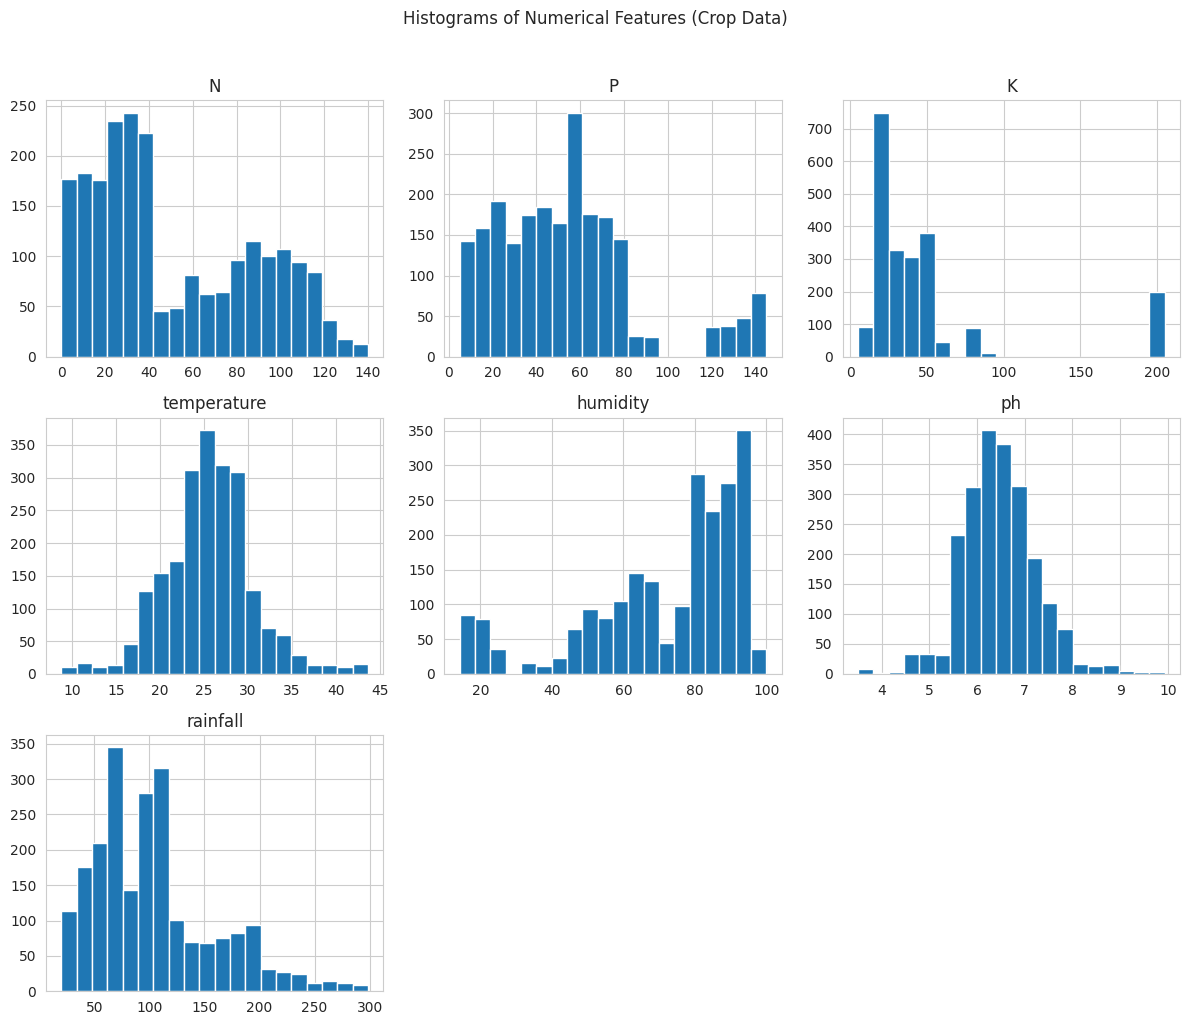

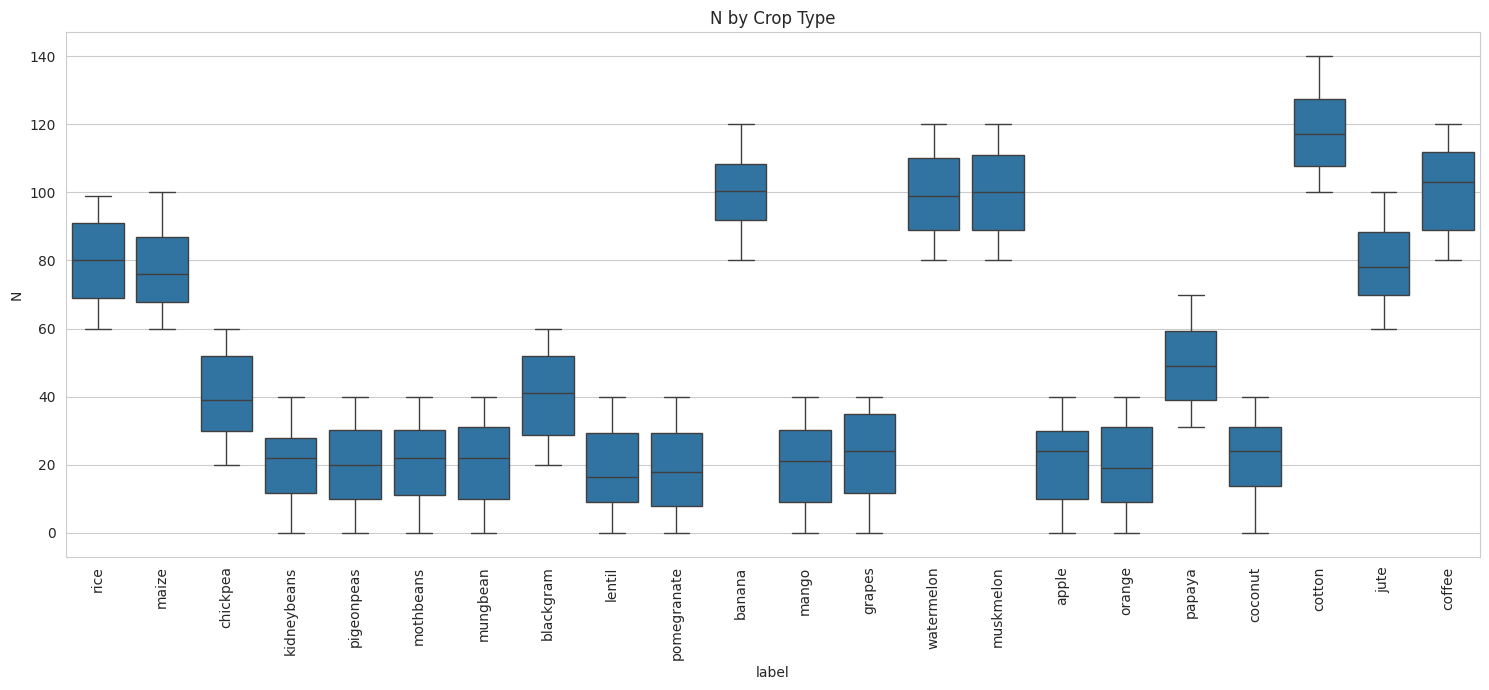

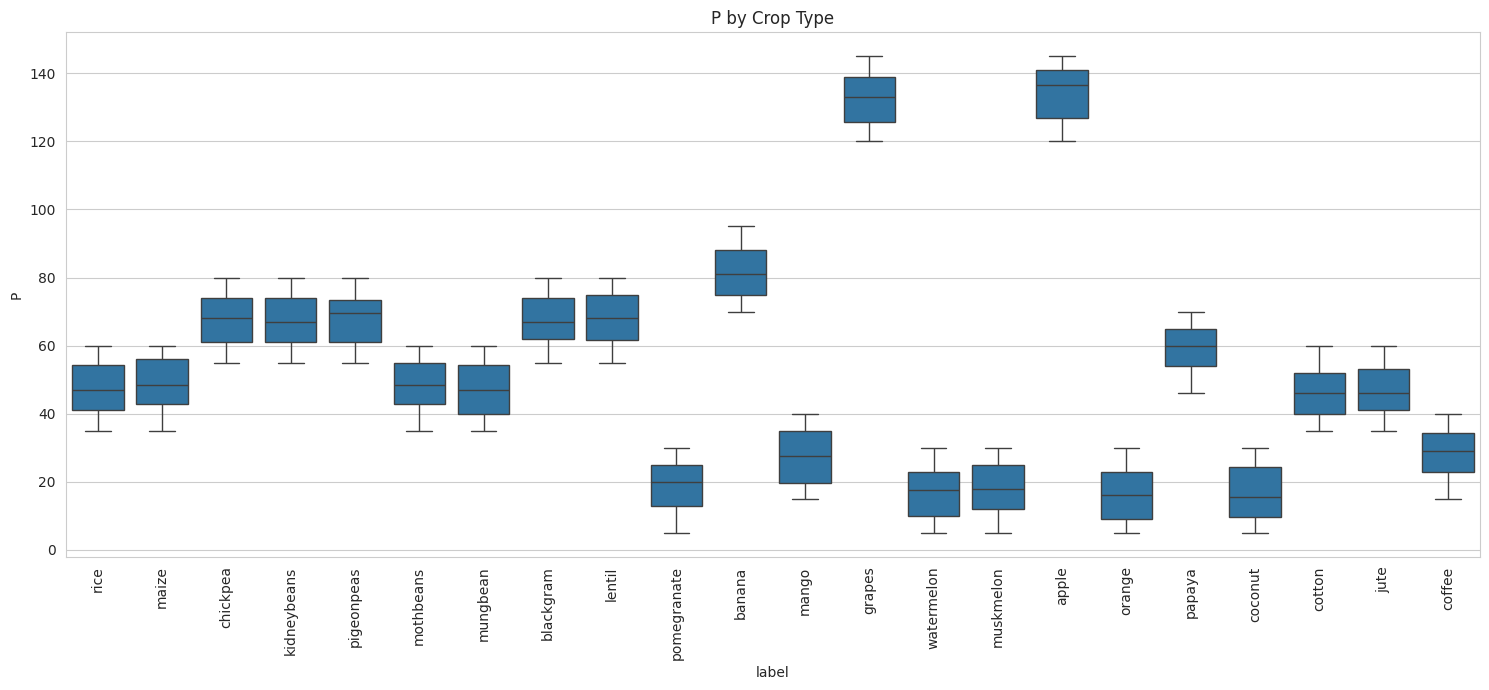

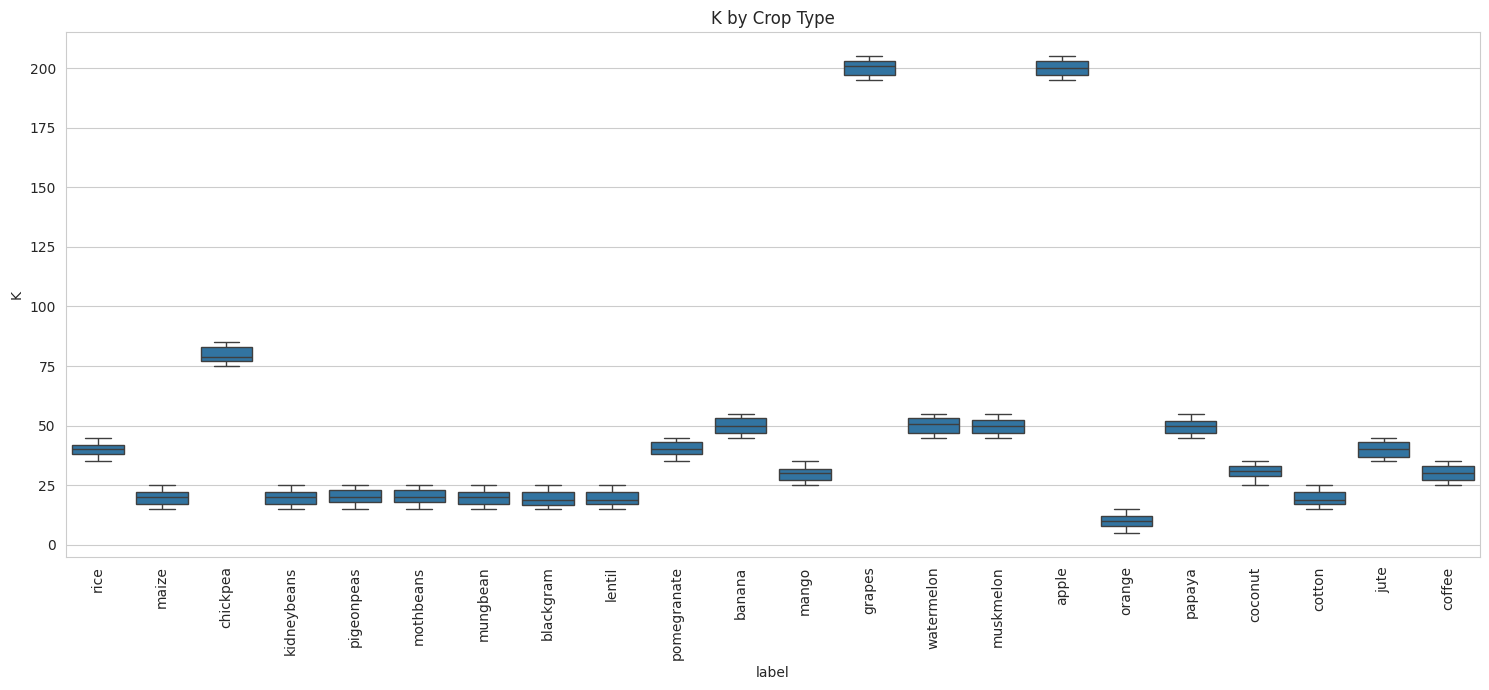

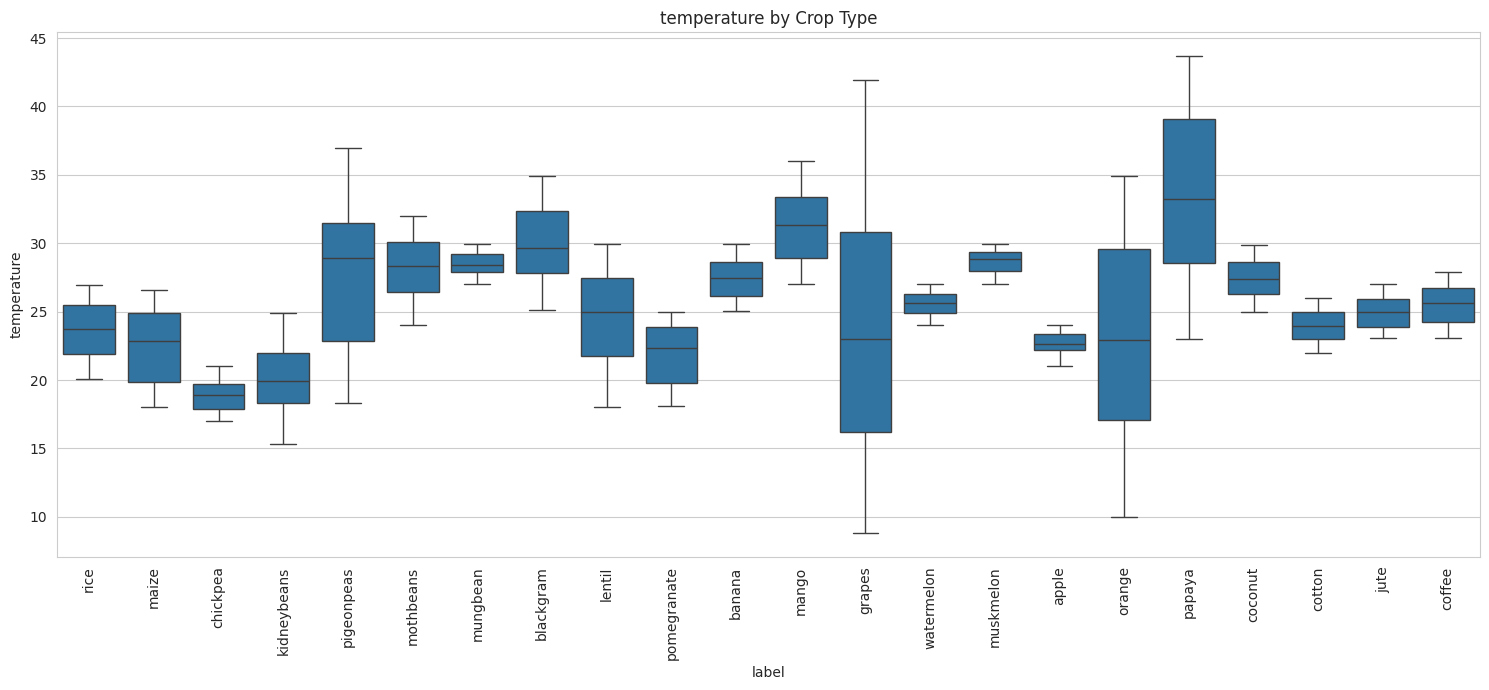

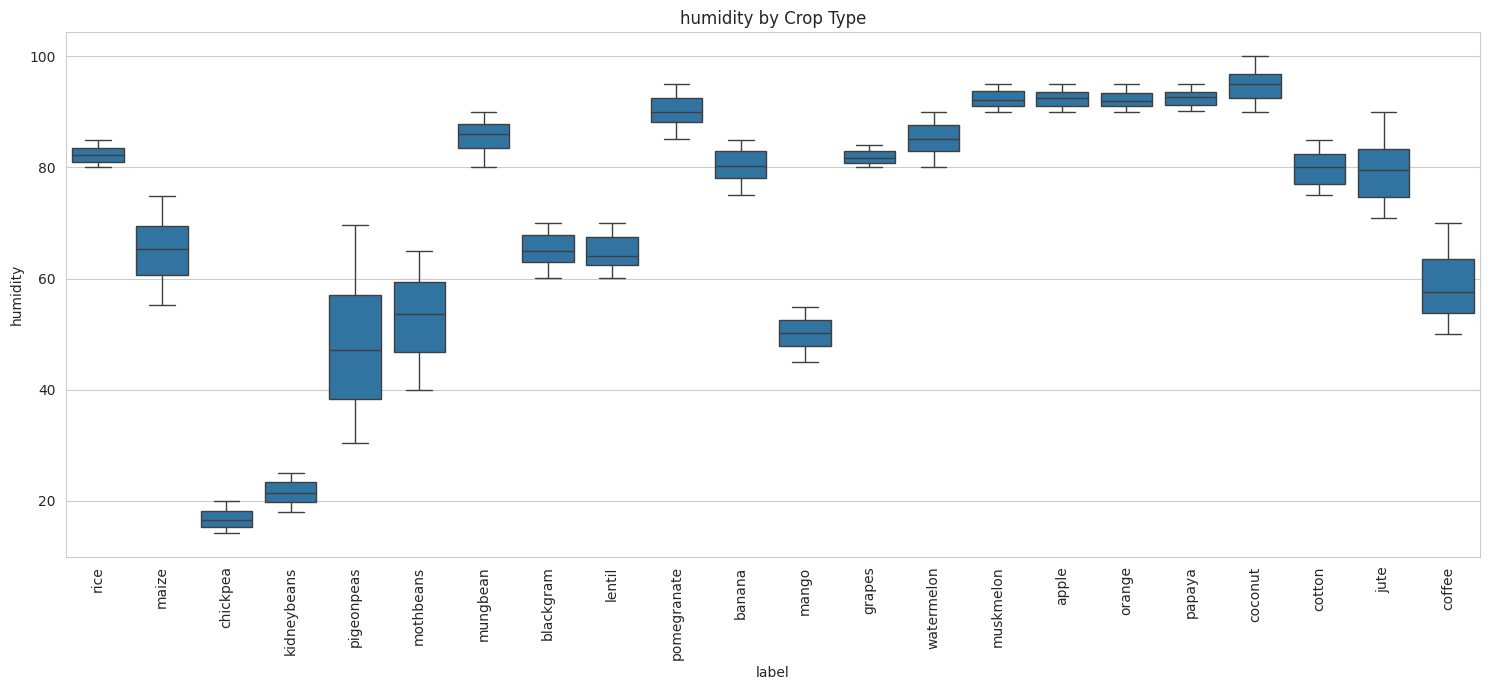

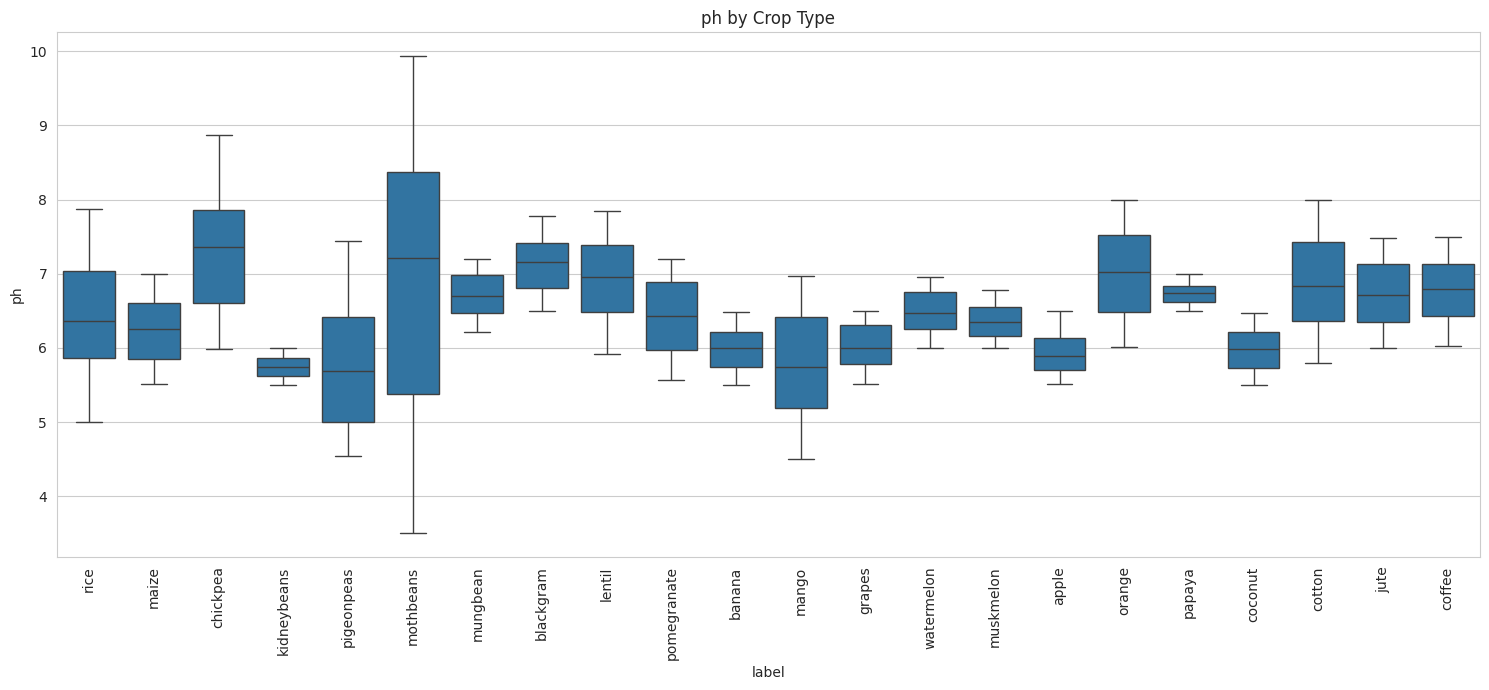

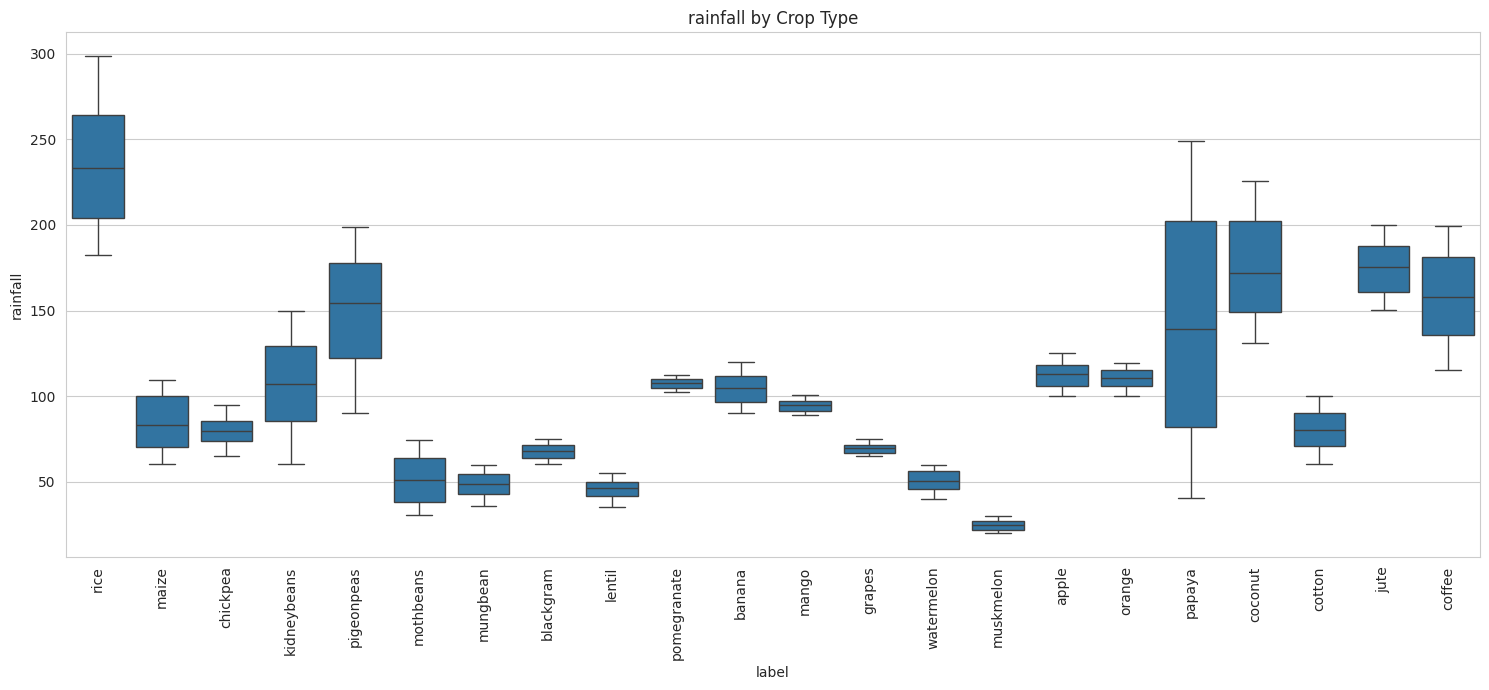

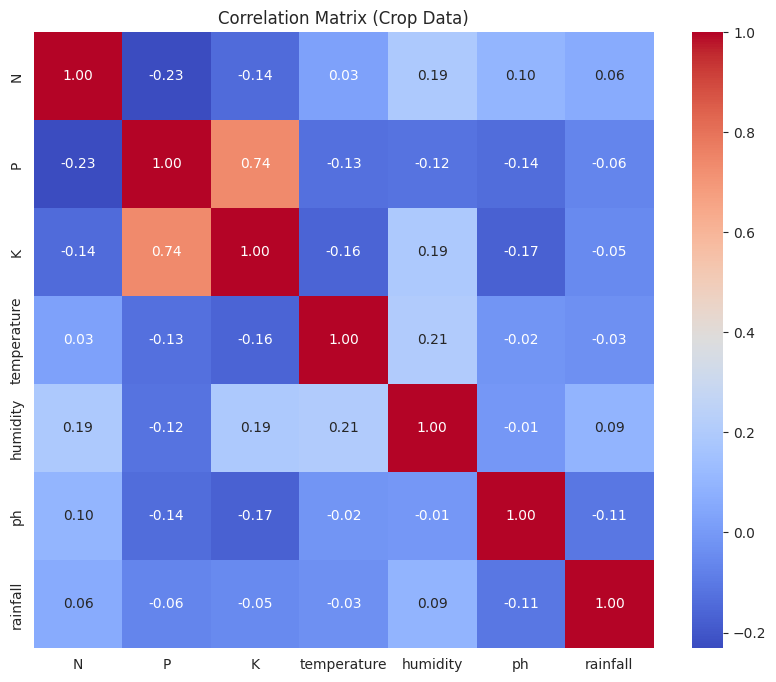

In [11]:
print("\n--- Crop Recommendation Dataset ---")
if 'crop_df' in locals():
    print("First 5 rows:\n", crop_df.head())
    print("\nShape of data:", crop_df.shape)
    print("\nData types:\n", crop_df.dtypes) # All seem numeric except label
    print("\nMissing values:\n", crop_df.isnull().sum()) # Usually no missing values in this dataset

    print("\nDescriptive statistics:\n", crop_df.describe())

    print("\nCrop Labels Distribution:")
    print(crop_df['label'].value_counts())
    plt.figure(figsize=(12, 6))
    sns.countplot(y='label', data=crop_df, order=crop_df['label'].value_counts().index)
    plt.title('Distribution of Crop Labels')
    plt.tight_layout()
    plt.show()

    # Histograms for numerical features
    crop_df.drop('label', axis=1).hist(figsize=(12, 10), bins=20)
    plt.suptitle('Histograms of Numerical Features (Crop Data)', y=1.02)
    plt.tight_layout()
    plt.show()

    # Boxplots to see feature distribution per crop
    numerical_cols_crop = crop_df.select_dtypes(include=np.number).columns
    for col in numerical_cols_crop:
        plt.figure(figsize=(15, 7))
        sns.boxplot(x='label', y=col, data=crop_df)
        plt.title(f'{col} by Crop Type')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

    # Correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(crop_df[numerical_cols_crop].corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix (Crop Data)')
    plt.show()
else:
    print("crop_df not loaded. Skipping EDA for Crop Recommendation.")

2. Data Preprocessing for Crop Recommendation


In [12]:
if 'crop_df' in locals():
    X_crop = crop_df.drop('label', axis=1)
    y_crop_str = crop_df['label']

    # Encode the target variable (crop labels)
    label_encoder_crop = LabelEncoder()
    y_crop = label_encoder_crop.fit_transform(y_crop_str)
    print("\nEncoded Crop Labels Mapping:")
    for i, class_name in enumerate(label_encoder_crop.classes_):
        print(f"{class_name}: {i}")


    # Split data into training and testing sets
    X_train_crop, X_test_crop, y_train_crop, y_test_crop = train_test_split(
        X_crop, y_crop, test_size=0.2, random_state=42, stratify=y_crop
    )

    # Feature Scaling (Numerical features)
    # All features are numerical, so we can apply StandardScaler to all of X
    scaler_crop = StandardScaler()
    X_train_crop_scaled = scaler_crop.fit_transform(X_train_crop)
    X_test_crop_scaled = scaler_crop.transform(X_test_crop)

    print("\nShape of X_train_crop_scaled:", X_train_crop_scaled.shape)
    print("Shape of X_test_crop_scaled:", X_test_crop_scaled.shape)
else:
    print("crop_df not loaded. Skipping Preprocessing for Crop Recommendation.")


Encoded Crop Labels Mapping:
apple: 0
banana: 1
blackgram: 2
chickpea: 3
coconut: 4
coffee: 5
cotton: 6
grapes: 7
jute: 8
kidneybeans: 9
lentil: 10
maize: 11
mango: 12
mothbeans: 13
mungbean: 14
muskmelon: 15
orange: 16
papaya: 17
pigeonpeas: 18
pomegranate: 19
rice: 20
watermelon: 21

Shape of X_train_crop_scaled: (1760, 7)
Shape of X_test_crop_scaled: (440, 7)


3. Model Selection & Training for Crop Recommendation

In [13]:
if 'crop_df' in locals():
    models_crop = {
        "Logistic Regression": LogisticRegression(max_iter=1000, solver='liblinear', multi_class='ovr', random_state=42),
        "K-Nearest Neighbors": KNeighborsClassifier(),
        "Decision Tree": DecisionTreeClassifier(random_state=42),
        "Random Forest": RandomForestClassifier(random_state=42),
        "Gradient Boosting": GradientBoostingClassifier(random_state=42)
    }

    results_crop = {}
    print("\n--- Training Crop Recommendation Models ---")

    for name, model in models_crop.items():
        model.fit(X_train_crop_scaled, y_train_crop)
        y_pred_crop = model.predict(X_test_crop_scaled)

        accuracy = accuracy_score(y_test_crop, y_pred_crop)
        # For multi-class, 'weighted' F1 is often a good summary
        f1 = f1_score(y_test_crop, y_pred_crop, average='weighted')
        results_crop[name] = {'Accuracy': accuracy, 'F1-score (Weighted)': f1}

        print(f"\n--- {name} (Crop Recommendation) ---")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1-score (Weighted): {f1:.4f}")
        # print("Classification Report:\n", classification_report(y_test_crop, y_pred_crop, target_names=label_encoder_crop.classes_, zero_division=0))
        # Detailed report can be long, so commented out for brevity here.

    crop_results_df = pd.DataFrame(results_crop).T.sort_values(by='Accuracy', ascending=False)
    print("\n--- Model Performance Summary (Crop Recommendation) ---")
    print(crop_results_df)
else:
    print("crop_df not loaded. Skipping Model Training for Crop Recommendation.")


--- Training Crop Recommendation Models ---

--- Logistic Regression (Crop Recommendation) ---
Accuracy: 0.9386
F1-score (Weighted): 0.9382

--- K-Nearest Neighbors (Crop Recommendation) ---
Accuracy: 0.9795
F1-score (Weighted): 0.9793

--- Decision Tree (Crop Recommendation) ---
Accuracy: 0.9795
F1-score (Weighted): 0.9794


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(



--- Random Forest (Crop Recommendation) ---
Accuracy: 0.9955
F1-score (Weighted): 0.9955

--- Gradient Boosting (Crop Recommendation) ---
Accuracy: 0.9886
F1-score (Weighted): 0.9887

--- Model Performance Summary (Crop Recommendation) ---
                     Accuracy  F1-score (Weighted)
Random Forest        0.995455             0.995452
Gradient Boosting    0.988636             0.988723
Decision Tree        0.979545             0.979423
K-Nearest Neighbors  0.979545             0.979283
Logistic Regression  0.938636             0.938216


4. Evaluation for Crop Recommendation


--- Detailed Evaluation for Random Forest (Crop Recommendation) ---
Classification Report:
               precision    recall  f1-score   support

       apple       1.00      1.00      1.00        20
      banana       1.00      1.00      1.00        20
   blackgram       1.00      0.95      0.97        20
    chickpea       1.00      1.00      1.00        20
     coconut       1.00      1.00      1.00        20
      coffee       1.00      1.00      1.00        20
      cotton       1.00      1.00      1.00        20
      grapes       1.00      1.00      1.00        20
        jute       0.95      1.00      0.98        20
 kidneybeans       1.00      1.00      1.00        20
      lentil       1.00      1.00      1.00        20
       maize       0.95      1.00      0.98        20
       mango       1.00      1.00      1.00        20
   mothbeans       1.00      1.00      1.00        20
    mungbean       1.00      1.00      1.00        20
   muskmelon       1.00      1.00      1.0

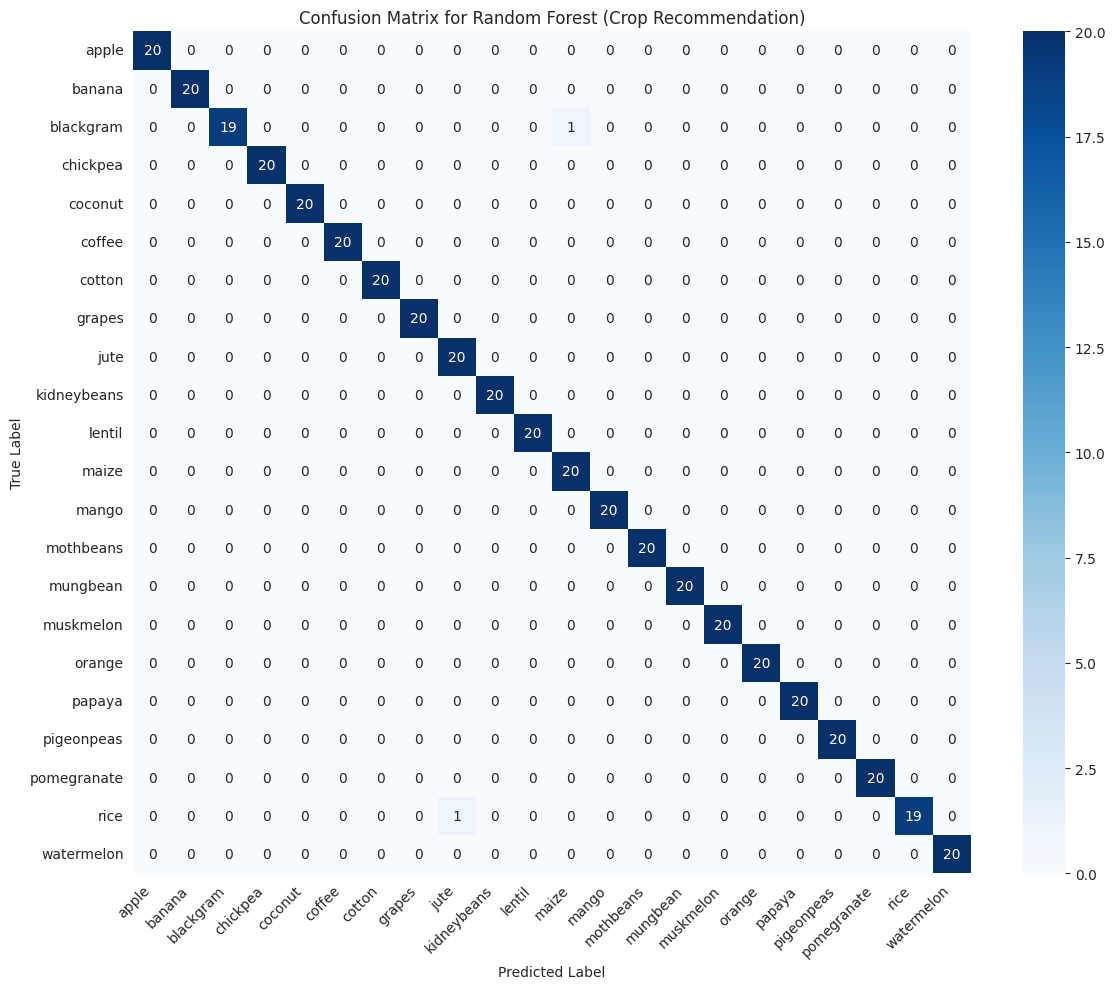

In [14]:
if 'crop_df' in locals():
    # Let's pick the best model based on accuracy (e.g., Random Forest or Gradient Boosting usually do well)
    # For demonstration, let's assume Random Forest is the best from the results_crop
    best_model_name_crop = crop_results_df.index[0]
    best_model_crop = models_crop[best_model_name_crop] # The trained model instance

    # Re-fit if not already (or get from a dictionary of trained models)
    # The models in `models_crop` are already fitted.
    # If you were to retrain the best one:
    # best_model_crop.fit(X_train_crop_scaled, y_train_crop)

    y_pred_best_crop = best_model_crop.predict(X_test_crop_scaled)

    print(f"\n--- Detailed Evaluation for {best_model_name_crop} (Crop Recommendation) ---")
    print("Classification Report:\n", classification_report(y_test_crop, y_pred_best_crop, target_names=label_encoder_crop.classes_, zero_division=0))

    cm_crop = confusion_matrix(y_test_crop, y_pred_best_crop)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_crop, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder_crop.classes_,
                yticklabels=label_encoder_crop.classes_)
    plt.title(f'Confusion Matrix for {best_model_name_crop} (Crop Recommendation)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print("crop_df not loaded. Skipping Evaluation for Crop Recommendation.")

#Project 2: Fertilizer Recommendation System

1. Exploratory Data Analysis (EDA) for Fertilizer Recommendation



--- Fertilizer Recommendation Dataset ---
First 5 rows:
    Temparature  Humidity  Moisture Soil Type  Crop Type  Nitrogen  Potassium  \
0           26        52        38     Sandy      Maize        37          0   
1           29        52        45     Loamy  Sugarcane        12          0   
2           34        65        62     Black     Cotton         7          9   
3           32        62        34       Red    Tobacco        22          0   
4           28        54        46    Clayey      Paddy        35          0   

   Phosphorous Fertilizer Name  
0            0            Urea  
1           36             DAP  
2           30        14-35-14  
3           20           28-28  
4            0            Urea  

Shape of data: (99, 9)

Data types:
 Temparature         int64
Humidity            int64
Moisture            int64
Soil Type          object
Crop Type          object
Nitrogen            int64
Potassium           int64
Phosphorous         int64
Fertilizer Name 

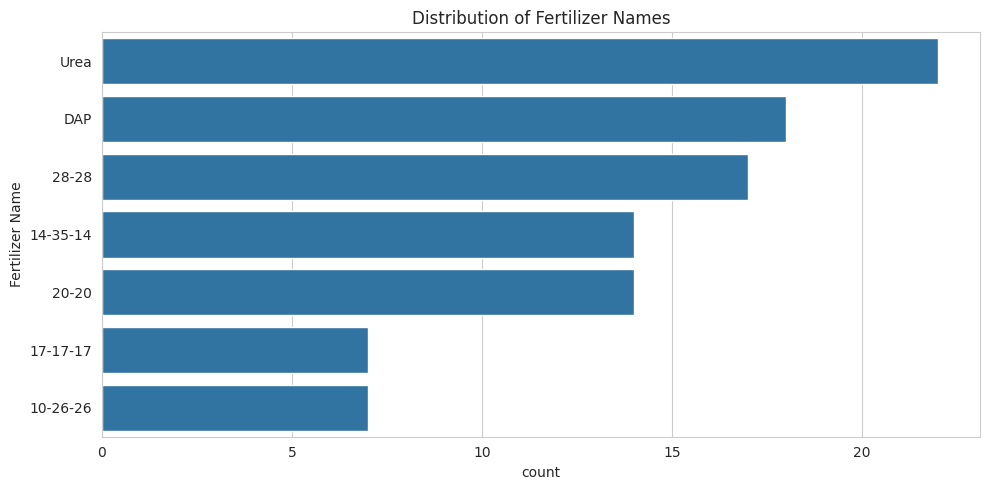


Soil Type Distribution:
Soil Type
Loamy     21
Sandy     20
Clayey    20
Black     19
Red       19
Name: count, dtype: int64


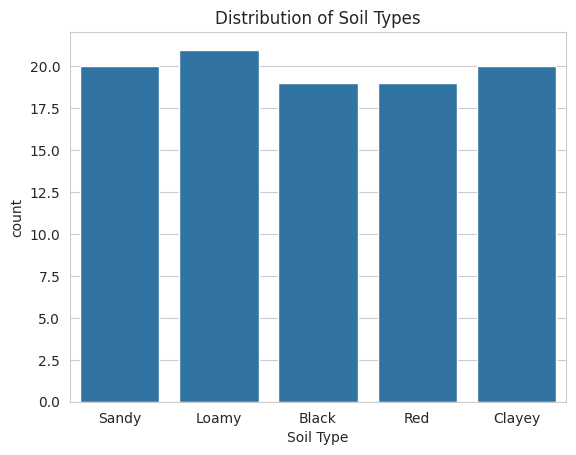


Crop Type Distribution:
Crop Type
Sugarcane      13
Cotton         12
Millets        11
Pulses         10
Paddy          10
Wheat           9
Barley          7
Oil seeds       7
Tobacco         7
Ground Nuts     7
Maize           6
Name: count, dtype: int64


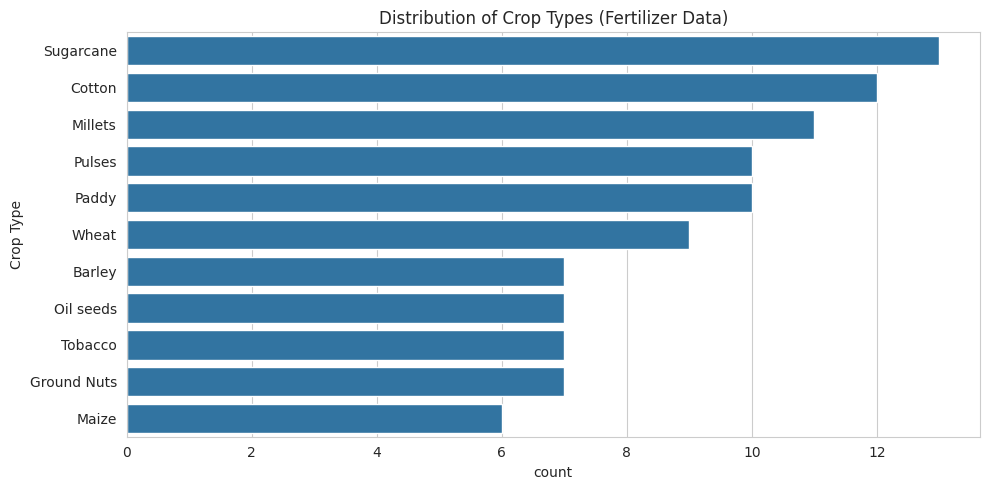

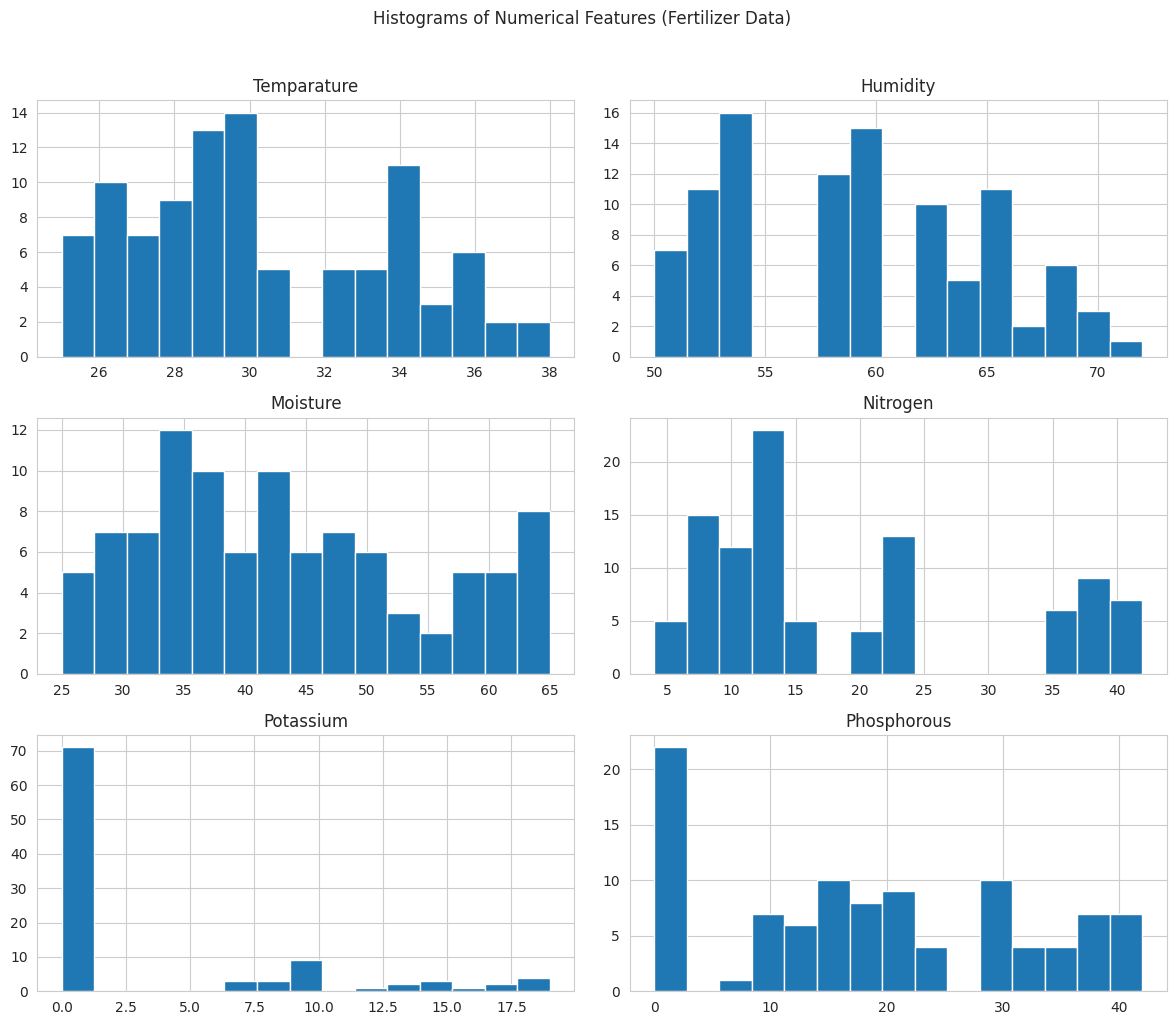

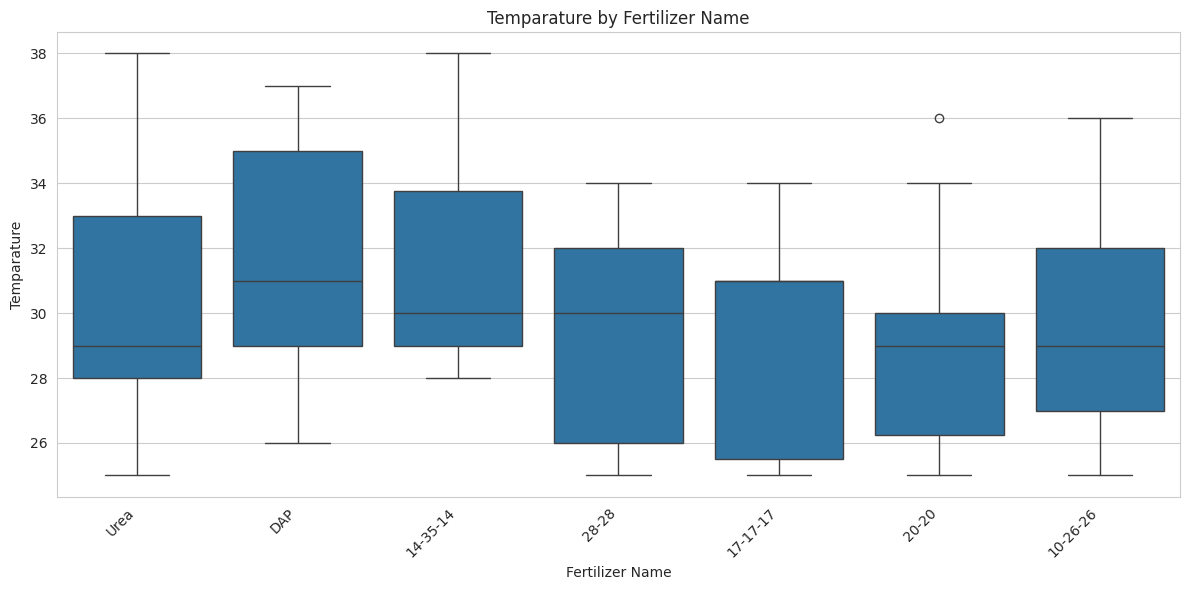

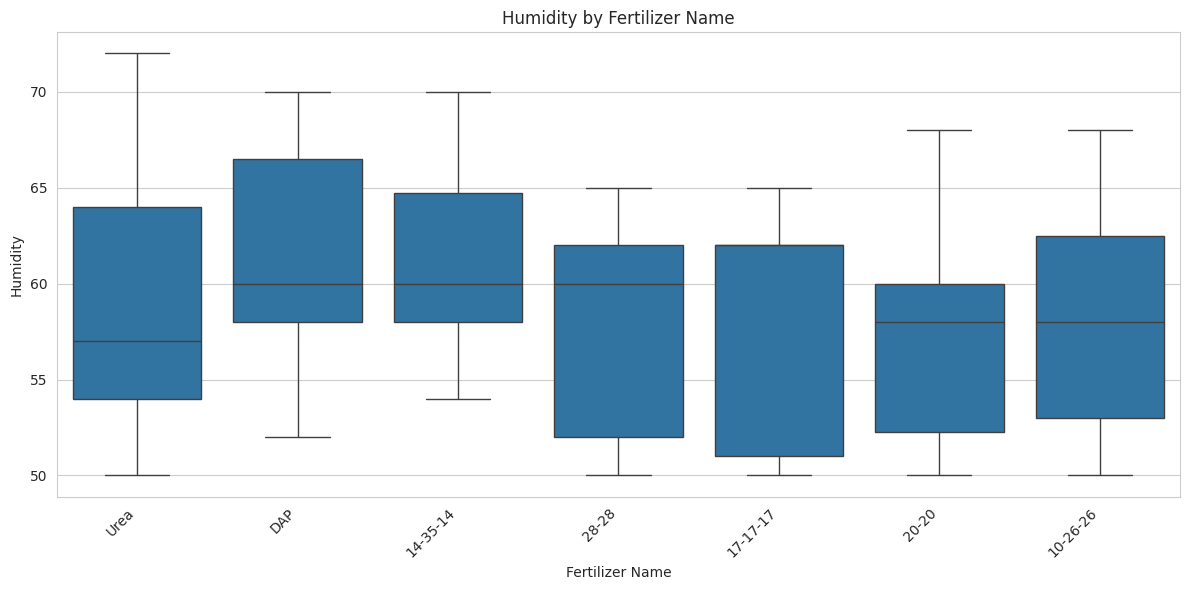

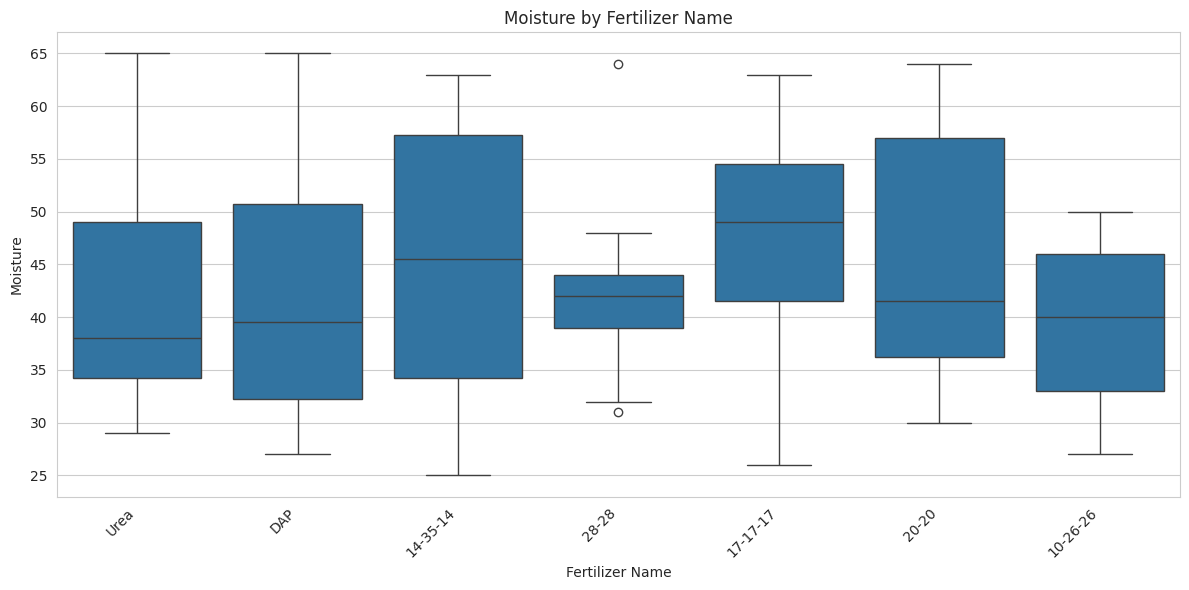

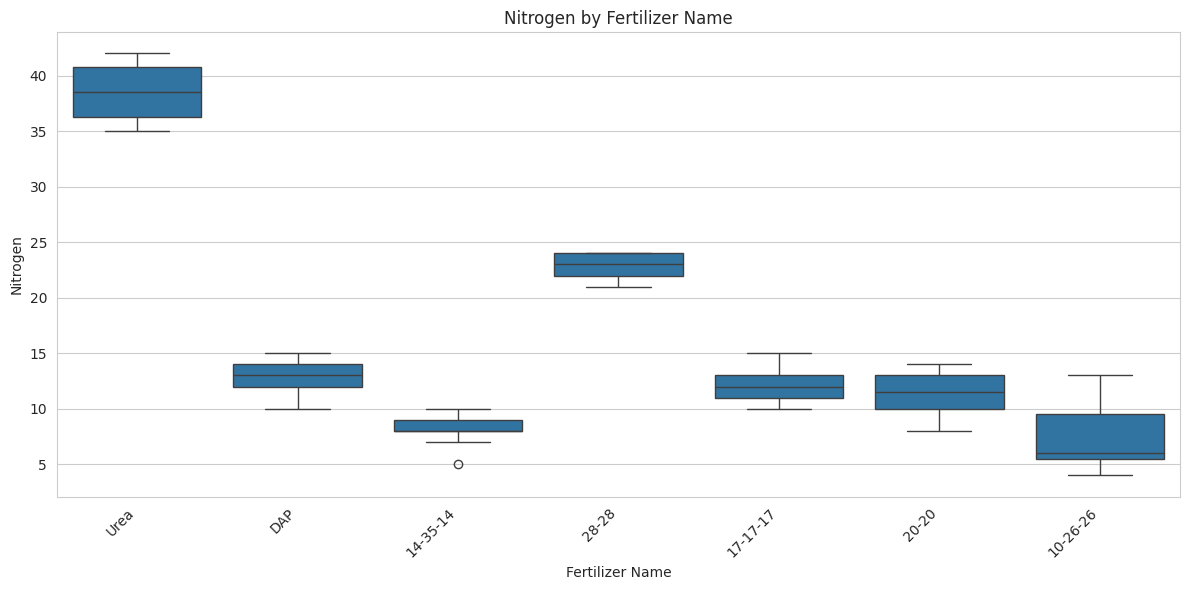

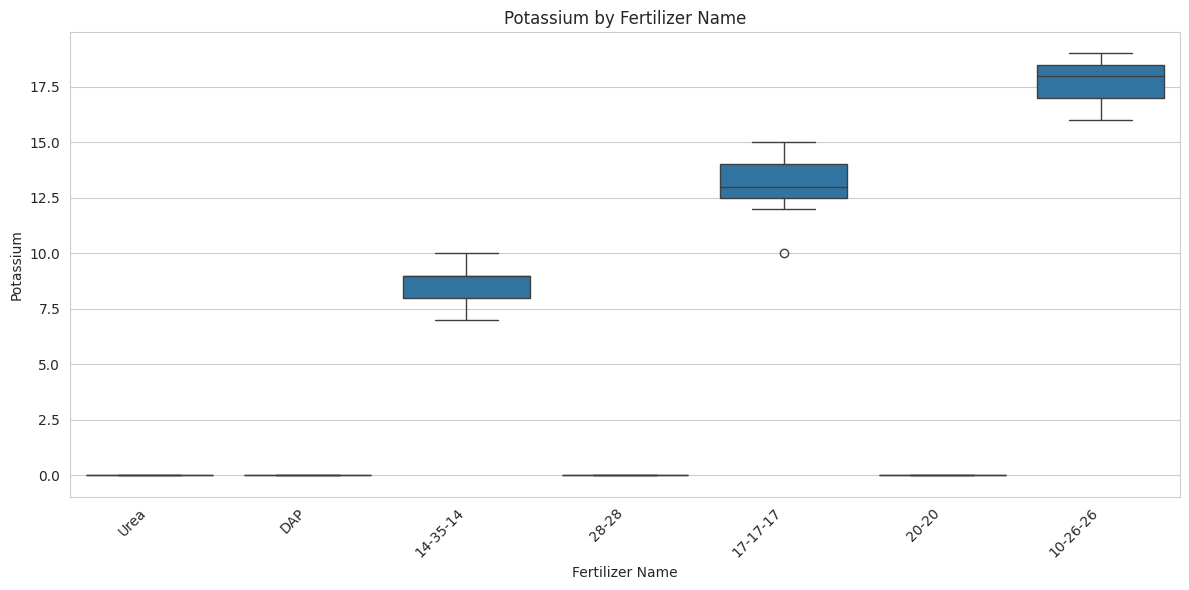

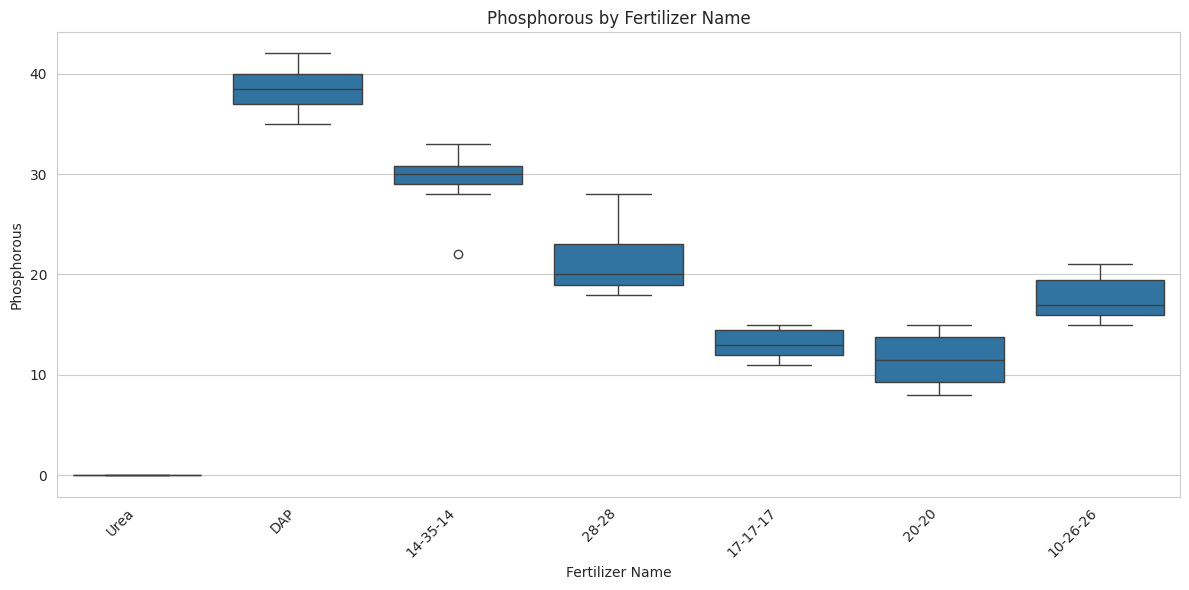

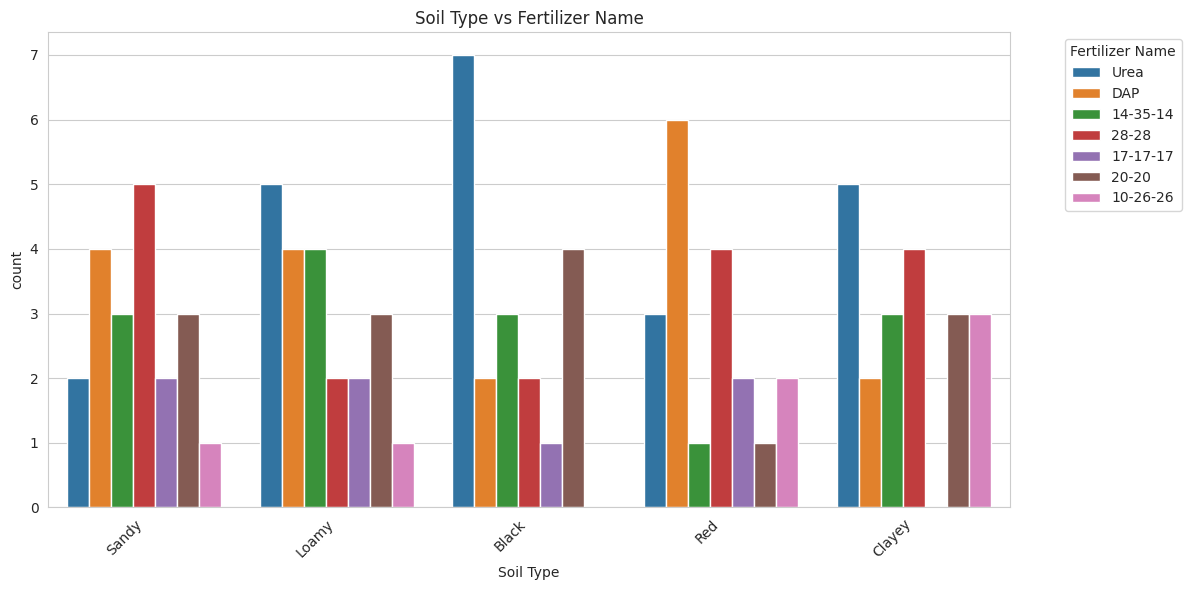

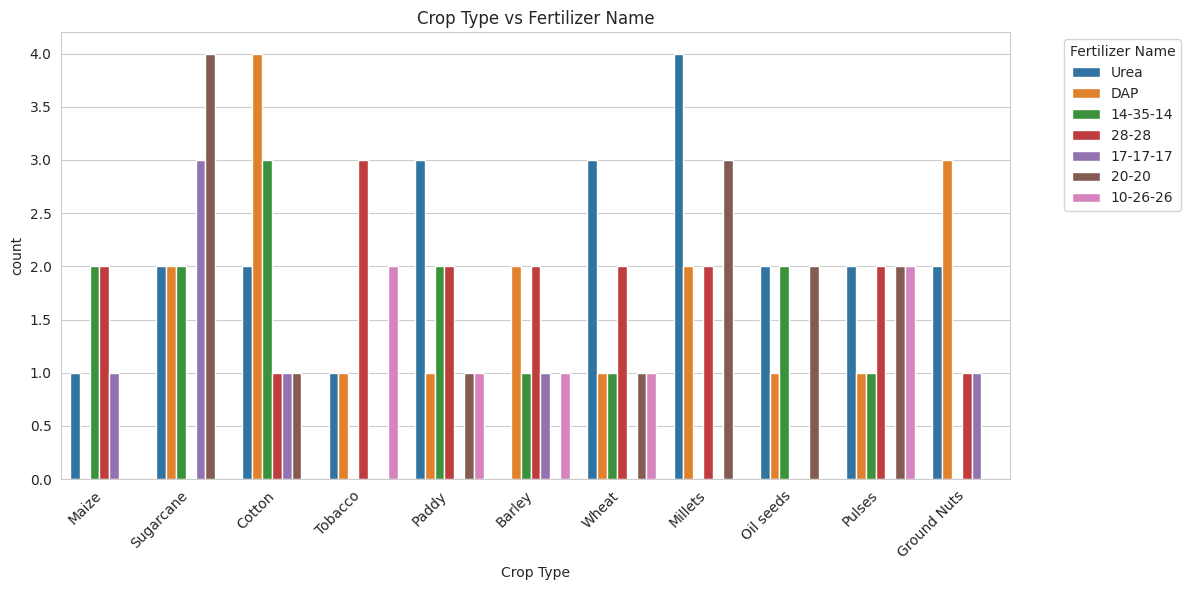

In [15]:
print("\n\n--- Fertilizer Recommendation Dataset ---")
if 'fertilizer_df' in locals():
    print("First 5 rows:\n", fertilizer_df.head())
    print("\nShape of data:", fertilizer_df.shape)
    print("\nData types:\n", fertilizer_df.dtypes)
    print("\nMissing values:\n", fertilizer_df.isnull().sum()) # Usually no missing values

    print("\nDescriptive statistics (numerical features):\n", fertilizer_df.describe())
    print("\nDescriptive statistics (categorical features):\n", fertilizer_df.describe(include='object'))

    print("\nFertilizer Name Distribution:")
    print(fertilizer_df['Fertilizer Name'].value_counts())
    plt.figure(figsize=(10, 5))
    sns.countplot(y='Fertilizer Name', data=fertilizer_df, order=fertilizer_df['Fertilizer Name'].value_counts().index)
    plt.title('Distribution of Fertilizer Names')
    plt.tight_layout()
    plt.show()

    print("\nSoil Type Distribution:")
    print(fertilizer_df['Soil Type'].value_counts())
    sns.countplot(x='Soil Type', data=fertilizer_df)
    plt.title('Distribution of Soil Types')
    plt.show()

    print("\nCrop Type Distribution:")
    print(fertilizer_df['Crop Type'].value_counts())
    plt.figure(figsize=(10,5))
    sns.countplot(y='Crop Type', data=fertilizer_df, order=fertilizer_df['Crop Type'].value_counts().index)
    plt.title('Distribution of Crop Types (Fertilizer Data)')
    plt.tight_layout()
    plt.show()

    # Histograms for numerical features
    numerical_cols_fert = fertilizer_df.select_dtypes(include=np.number).columns
    fertilizer_df[numerical_cols_fert].hist(figsize=(12, 10), bins=15)
    plt.suptitle('Histograms of Numerical Features (Fertilizer Data)', y=1.02)
    plt.tight_layout()
    plt.show()

    # Boxplots for numerical features vs Fertilizer Name
    for col in numerical_cols_fert:
        plt.figure(figsize=(12, 6))
        sns.boxplot(x='Fertilizer Name', y=col, data=fertilizer_df)
        plt.title(f'{col} by Fertilizer Name')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    # Categorical features vs Fertilizer Name
    for cat_col in ['Soil Type', 'Crop Type']:
        plt.figure(figsize=(12, 6))
        sns.countplot(x=cat_col, hue='Fertilizer Name', data=fertilizer_df)
        plt.title(f'{cat_col} vs Fertilizer Name')
        plt.xticks(rotation=45, ha='right')
        plt.legend(title='Fertilizer Name', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
else:
    print("fertilizer_df not loaded. Skipping EDA for Fertilizer Recommendation.")

2. Data Preprocessing for Fertilizer Recommendation

In [16]:
if 'fertilizer_df' in locals():
    X_fert = fertilizer_df.drop('Fertilizer Name', axis=1)
    y_fert_str = fertilizer_df['Fertilizer Name']

    # Encode the target variable (Fertilizer Name)
    label_encoder_fert = LabelEncoder()
    y_fert = label_encoder_fert.fit_transform(y_fert_str)
    print("\nEncoded Fertilizer Labels Mapping:")
    for i, class_name in enumerate(label_encoder_fert.classes_):
        print(f"{class_name}: {i}")


    # Identify numerical and categorical columns
    numerical_features_fert = X_fert.select_dtypes(include=np.number).columns.tolist()
    categorical_features_fert = X_fert.select_dtypes(include='object').columns.tolist()

    print("\nNumerical features for fertilizer:", numerical_features_fert)
    print("Categorical features for fertilizer:", categorical_features_fert)

    # Create preprocessor
    # Numerical pipeline: Standard scaling
    # Categorical pipeline: One-hot encoding
    preprocessor_fert = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features_fert),
            ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features_fert)
        ],
        remainder='passthrough' # Keep any other columns (should be none here)
    )

    # Split data
    X_train_fert, X_test_fert, y_train_fert, y_test_fert = train_test_split(
        X_fert, y_fert, test_size=0.2, random_state=42, stratify=y_fert
    )

    # Apply preprocessing
    # Fit on training data and transform both train and test
    X_train_fert_processed = preprocessor_fert.fit_transform(X_train_fert)
    X_test_fert_processed = preprocessor_fert.transform(X_test_fert)

    # Get feature names after one-hot encoding for interpretability later (optional)
    try:
        ohe_feature_names = preprocessor_fert.named_transformers_['cat'].get_feature_names_out(categorical_features_fert)
        all_feature_names_fert = numerical_features_fert + list(ohe_feature_names)
        print("\nTotal features after processing:", len(all_feature_names_fert))
    except Exception as e:
        print(f"Could not get OHE feature names: {e}")


    print("\nShape of X_train_fert_processed:", X_train_fert_processed.shape)
    print("Shape of X_test_fert_processed:", X_test_fert_processed.shape)
else:
    print("fertilizer_df not loaded. Skipping Preprocessing for Fertilizer Recommendation.")


Encoded Fertilizer Labels Mapping:
10-26-26: 0
14-35-14: 1
17-17-17: 2
20-20: 3
28-28: 4
DAP: 5
Urea: 6

Numerical features for fertilizer: ['Temparature', 'Humidity', 'Moisture', 'Nitrogen', 'Potassium', 'Phosphorous']
Categorical features for fertilizer: ['Soil Type', 'Crop Type']

Total features after processing: 20

Shape of X_train_fert_processed: (79, 20)
Shape of X_test_fert_processed: (20, 20)


3. Model Selection & Training for Fertilizer Recommendation

In [17]:
if 'fertilizer_df' in locals():
    # Using similar models as for crop recommendation
    models_fert = {
        "Logistic Regression": LogisticRegression(max_iter=1000, solver='liblinear', multi_class='ovr', random_state=42),
        "K-Nearest Neighbors": KNeighborsClassifier(),
        "Decision Tree": DecisionTreeClassifier(random_state=42),
        "Random Forest": RandomForestClassifier(random_state=42),
        "Gradient Boosting": GradientBoostingClassifier(random_state=42)
    }

    results_fert = {}
    print("\n--- Training Fertilizer Recommendation Models ---")

    for name, model in models_fert.items():
        # Create a full pipeline for each model to ensure preprocessing is part of CV if used later
        # For now, we use pre-processed data directly
        model.fit(X_train_fert_processed, y_train_fert)
        y_pred_fert = model.predict(X_test_fert_processed)

        accuracy = accuracy_score(y_test_fert, y_pred_fert)
        f1 = f1_score(y_test_fert, y_pred_fert, average='weighted')
        results_fert[name] = {'Accuracy': accuracy, 'F1-score (Weighted)': f1}

        print(f"\n--- {name} (Fertilizer Recommendation) ---")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1-score (Weighted): {f1:.4f}")

    fert_results_df = pd.DataFrame(results_fert).T.sort_values(by='Accuracy', ascending=False)
    print("\n--- Model Performance Summary (Fertilizer Recommendation) ---")
    print(fert_results_df)
else:
    print("fertilizer_df not loaded. Skipping Model Training for Fertilizer Recommendation.")


--- Training Fertilizer Recommendation Models ---

--- Logistic Regression (Fertilizer Recommendation) ---
Accuracy: 0.9500
F1-score (Weighted): 0.9333

--- K-Nearest Neighbors (Fertilizer Recommendation) ---
Accuracy: 0.9000
F1-score (Weighted): 0.8986

--- Decision Tree (Fertilizer Recommendation) ---
Accuracy: 0.9500
F1-score (Weighted): 0.9533


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(



--- Random Forest (Fertilizer Recommendation) ---
Accuracy: 1.0000
F1-score (Weighted): 1.0000

--- Gradient Boosting (Fertilizer Recommendation) ---
Accuracy: 0.9500
F1-score (Weighted): 0.9473

--- Model Performance Summary (Fertilizer Recommendation) ---
                     Accuracy  F1-score (Weighted)
Random Forest            1.00             1.000000
Logistic Regression      0.95             0.933333
Decision Tree            0.95             0.953333
Gradient Boosting        0.95             0.947273
K-Nearest Neighbors      0.90             0.898571


4. Evaluation for Fertilizer Recommendation


--- Detailed Evaluation for Random Forest (Fertilizer Recommendation) ---
Classification Report:
               precision    recall  f1-score   support

    10-26-26       1.00      1.00      1.00         1
    14-35-14       1.00      1.00      1.00         3
    17-17-17       1.00      1.00      1.00         1
       20-20       1.00      1.00      1.00         3
       28-28       1.00      1.00      1.00         3
         DAP       1.00      1.00      1.00         4
        Urea       1.00      1.00      1.00         5

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



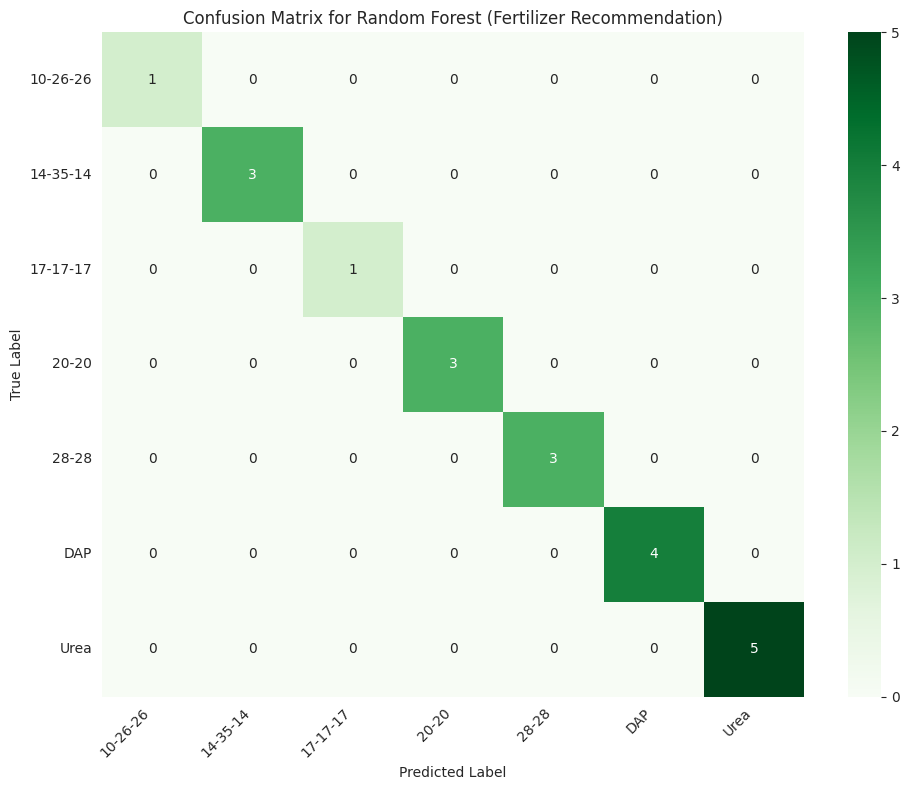

In [18]:
if 'fertilizer_df' in locals():
    best_model_name_fert = fert_results_df.index[0]
    best_model_fert = models_fert[best_model_name_fert] # The trained model instance

    y_pred_best_fert = best_model_fert.predict(X_test_fert_processed)

    print(f"\n--- Detailed Evaluation for {best_model_name_fert} (Fertilizer Recommendation) ---")
    print("Classification Report:\n", classification_report(y_test_fert, y_pred_best_fert, target_names=label_encoder_fert.classes_, zero_division=0))

    cm_fert = confusion_matrix(y_test_fert, y_pred_best_fert)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_fert, annot=True, fmt='d', cmap='Greens',
                xticklabels=label_encoder_fert.classes_,
                yticklabels=label_encoder_fert.classes_)
    plt.title(f'Confusion Matrix for {best_model_name_fert} (Fertilizer Recommendation)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print("fertilizer_df not loaded. Skipping Evaluation for Fertilizer Recommendation.")